Training Loss: 0.0000
Testing Loss: 0.1594


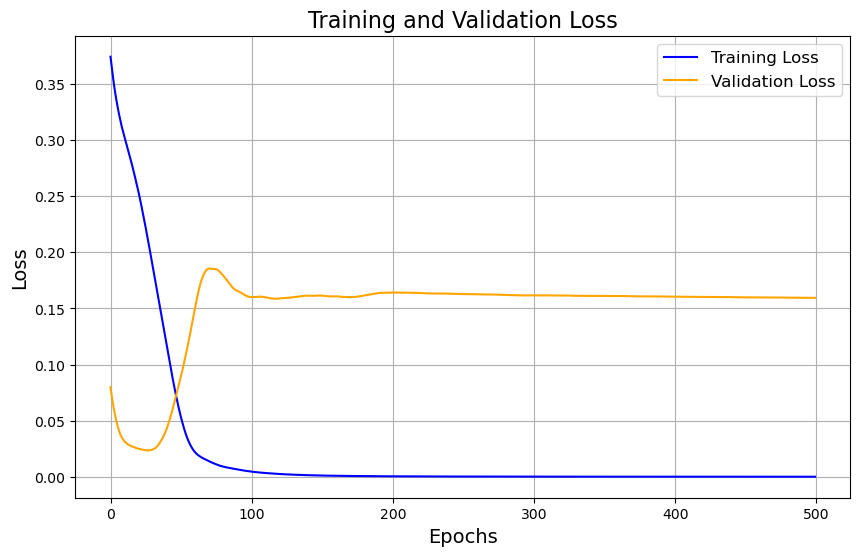

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


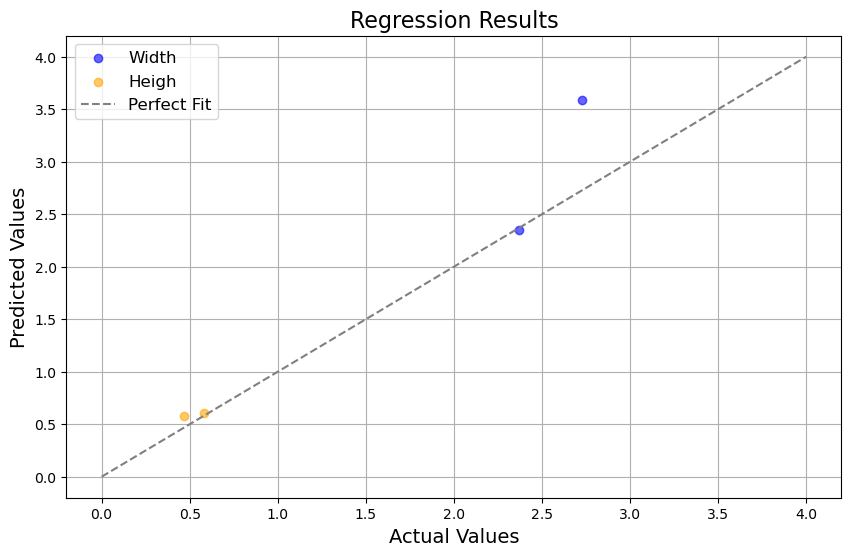

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


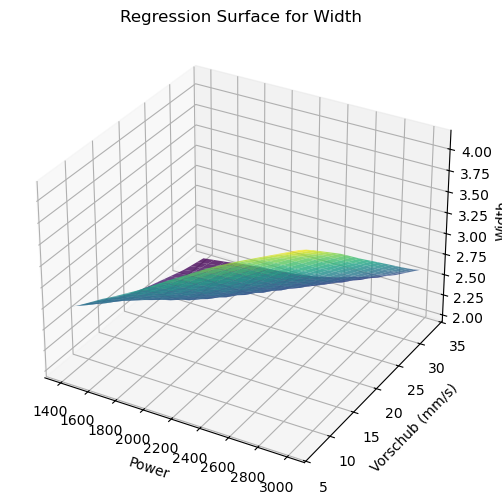

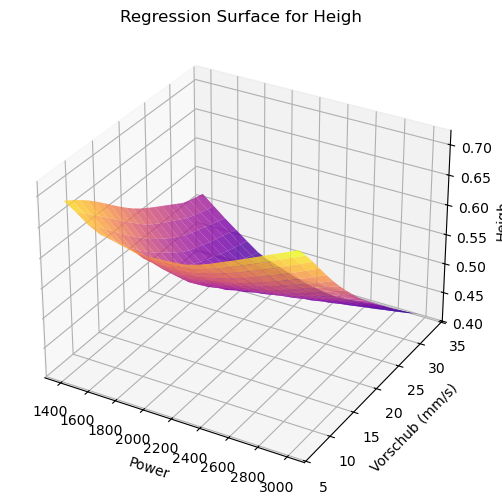

Enter Power (e.g., 2000):  2300
Enter Vorschub (mm/s) (e.g., 16.67):  14
Enter Draht Vorschub (m/min) (e.g., 1.2):  1.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Width: 3.1343
Predicted Heigh: 0.5638


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Define the data
data = {
    "Sample Number": [1, 2, 3, 4, 5, 6, 7, 8],
    "Power": [3000, 3000, 2000, 2000, 1400, 1400, 1700, 1700],
    "Vorschub (mm/s)": [33.33, 16.67, 16.67, 6.67, 6.67, 16.67, 16.67, 6.67],
    "Draht Vorschub (m/min)": [2, 1.2, 1.2, 0.8, 0.8, 1.2, 1.2, 0.8],
    "Width": [2.481916667, 2.72565625, 2.57078125, 3.55234375, 2.9704375, 2.36746875, 2.48675, 3.29384375],
    "Heigh": [0.426137532, 0.467315146, 0.515392011, 0.663825292, 0.758660988, 0.583955369, 0.538065193, 0.699688111]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Step 2: Normalize the data
features = df[["Power", "Vorschub (mm/s)", "Draht Vorschub (m/min)"]]
targets = df[["Width", "Heigh"]]

scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

features_normalized = scaler_features.fit_transform(features)
targets_normalized = scaler_targets.fit_transform(targets)

# Step 3: Split the data into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features_normalized, targets_normalized, test_size=0.25, random_state=42
)

# Step 4: Define the Neural Network
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(2)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Step 5: Train the model
history = model.fit(features_train, targets_train, epochs=500, verbose=0, validation_data=(features_test, targets_test))

# Step 6: Evaluate the model
train_loss = model.evaluate(features_train, targets_train, verbose=0)
test_loss = model.evaluate(features_test, targets_test, verbose=0)

print(f"Training Loss: {train_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

# Step 7: Visualize training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Step 8: Predict values for test data
predictions_normalized = model.predict(features_test)
predictions = scaler_targets.inverse_transform(predictions_normalized)
actuals = scaler_targets.inverse_transform(targets_test)

# Step 9: Visualize regression results for Width and Heigh
plt.figure(figsize=(10, 6))
plt.scatter(actuals[:, 0], predictions[:, 0], color='blue', label='Width', alpha=0.6)
plt.scatter(actuals[:, 1], predictions[:, 1], color='orange', label='Heigh', alpha=0.6)
plt.plot([0, 4], [0, 4], color='gray', linestyle='--', label='Perfect Fit')
plt.title('Regression Results', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Step 10: Visualize regression surfaces for Width and Heigh
power_range = np.linspace(df["Power"].min(), df["Power"].max(), 20)
vorschub_range = np.linspace(df["Vorschub (mm/s)"].min(), df["Vorschub (mm/s)"].max(), 20)

power, vorschub = np.meshgrid(power_range, vorschub_range)
draht_constant = np.mean(df["Draht Vorschub (m/min)"])

# Generate grid data
grid = np.c_[power.ravel(), vorschub.ravel(), np.full_like(power.ravel(), draht_constant)]
grid_normalized = scaler_features.transform(grid)

# Predict on grid
grid_predictions_normalized = model.predict(grid_normalized)
grid_predictions = scaler_targets.inverse_transform(grid_predictions_normalized)

# Reshape predictions
width_surface = grid_predictions[:, 0].reshape(power.shape)
heigh_surface = grid_predictions[:, 1].reshape(power.shape)

# Plot Width surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(power, vorschub, width_surface, cmap='viridis', alpha=0.8)
ax.set_xlabel('Power')
ax.set_ylabel('Vorschub (mm/s)')
ax.set_zlabel('Width')
ax.set_title('Regression Surface for Width')
plt.show()

# Plot Heigh surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(power, vorschub, heigh_surface, cmap='plasma', alpha=0.8)
ax.set_xlabel('Power')
ax.set_ylabel('Vorschub (mm/s)')
ax.set_zlabel('Heigh')
ax.set_title('Regression Surface for Heigh')
plt.show()

# Example usage: Predict for new user inputs
def predict_user_input(power, vorschub, draht_vorschub):
    # Normalize user inputs
    input_features = scaler_features.transform([[power, vorschub, draht_vorschub]])
    
    # Predict normalized output
    normalized_output = model.predict(input_features)
    
    # Denormalize the output
    output = scaler_targets.inverse_transform(normalized_output)
    return output[0]

# Get user inputs
user_power = float(input("Enter Power (e.g., 2000): "))
user_vorschub = float(input("Enter Vorschub (mm/s) (e.g., 16.67): "))
user_draht_vorschub = float(input("Enter Draht Vorschub (m/min) (e.g., 1.2): "))

predicted_values = predict_user_input(user_power, user_vorschub, user_draht_vorschub)
print(f"Predicted Width: {predicted_values[0]:.4f}")
print(f"Predicted Heigh: {predicted_values[1]:.4f}")
